### 필요 라이브러리 호출

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import yfinance as yf

from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
import platform
if platform.system() == 'Darwin': # MAC
    plt.rc('font', family='AppleGothic')
else: # Windows
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False

### 데이터 수집

In [43]:
# symbol = '^GSPC' # 종목 symbol
# name = 'S&P500' # 종목 name

# symbol = '^IXIC' # 종목 symbol
# name = 'NASDAQ' # 종목 name

# name = 'KOSPI'
# symbol = '^KS11'

name = 'KOSDAQ'
symbol = '^KQ11' # 종목 symbol

# ohlcv 데이터 수집 (전체 기간)
df = yf.download(symbol)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-10-16,858.500000,873.900024,851.299988,867.099976,867.099976,193900
2000-10-17,849.599976,860.099976,791.099976,804.000000,804.000000,218200
2000-10-18,788.500000,811.400024,758.200012,802.599976,802.599976,241000
2000-10-19,793.599976,820.400024,786.900024,798.400024,798.400024,204500
2000-10-20,834.700012,840.900024,822.500000,826.200012,826.200012,221900


### 데이터 전처리

#### 불필요한 컬럼 제거

In [44]:
col_price = 'Close'
df = df[[col_price]]
df

,Close
Date,
2000-10-16,867.099976
2000-10-17,804.000000
2000-10-18,802.599976
2000-10-19,798.400024
2000-10-20,826.200012
...,...
2023-12-21,859.440002
2023-12-22,854.619995
2023-12-26,848.340027


#### 결측치 처리
- 이전 값으로 채우기
- 이후 결측치 제거

In [45]:
df = df.fillna(method='ffill').dropna()

#### 일일수익률 계산

In [46]:
# 일일수익률 컬럼명 설정
col_rtn = 'Daily Returns'

df[col_rtn] = df[col_price].pct_change() * 100
df = df.dropna()

#### 산타랠리 기간 설정

In [47]:
col_period = 'period'

val_period = ['Remaining Days', 'SantaClausRally Days']
df[col_period] = val_period[0]

days_tail = 5 # 12월
days_head = 2 # 1월

# 구분년도 설정
col_year = 'year'
df[col_year] = df.index.year

years = df.index.year.unique()
for year in years:
    year = str(year)
    if year+'-12' in df.index:
        df.loc[year+'-12', col_period].iloc[-days_tail:] = val_period[1]
    if year+'-01' in df.index:
        df.loc[year+'-01', col_period].iloc[:days_head] = val_period[1]
        df.loc[year+'-01', col_year].iloc[:days_head] = int(year)-1

#### 데이터 기간 설정

In [48]:
# date_start = '2000-01-01'
date_start = '2000-11-01' # KOSDAQ
date_end = '2021-12-31'

df = df.loc[date_start:date_end]

#### 최종 데이터 정보(요약통계량)

In [49]:
df.head()

,Close,Daily Returns,period,year
Date,,,,
2000-11-01,763.599976,2.249597,Remaining Days,2000
2000-11-02,782.500000,2.475121,Remaining Days,2000
2000-11-03,795.400024,1.648565,Remaining Days,2000
2000-11-06,804.599976,1.156645,Remaining Days,2000
2000-11-07,796.299988,-1.031567,Remaining Days,2000


In [50]:
df.tail()

,Close,Daily Returns,period,year
Date,,,,
2021-12-24,1007.419983,0.409643,SantaClausRally Days,2021
2021-12-27,1011.359985,0.391098,SantaClausRally Days,2021
2021-12-28,1027.439941,1.589934,SantaClausRally Days,2021
2021-12-29,1028.050049,0.059381,SantaClausRally Days,2021
2021-12-30,1033.979980,0.576814,SantaClausRally Days,2021


In [51]:
df[[col_rtn]].describe()

,Daily Returns
count,5227.000000
mean,0.019145
std,1.600561
min,-11.705901
25%,-0.634012
50%,0.142362
75%,0.826250
max,11.468802


## 산타랠리 비교

In [52]:
rtns_santa = df[df[col_period]==val_period[1]][col_rtn]
rtns_remaining = df[df[col_period]==val_period[0]][col_rtn]

### 일 평균 수익률 비교

In [53]:
df.groupby(col_period)[[col_rtn]].agg(['mean', 'std', 'min', 'max', 'count'])

Daily Returns                                      
                              mean       std        min        max count
period                                                                  
Remaining Days            0.011335  1.592774 -11.705901  11.468802  5075
SantaClausRally Days      0.279886  1.828634  -6.971611   5.933818   152

In [54]:
## 1월 첫 2일 -> 전년도로 구분
# df[df.index.year!=df[col_year]]

[]

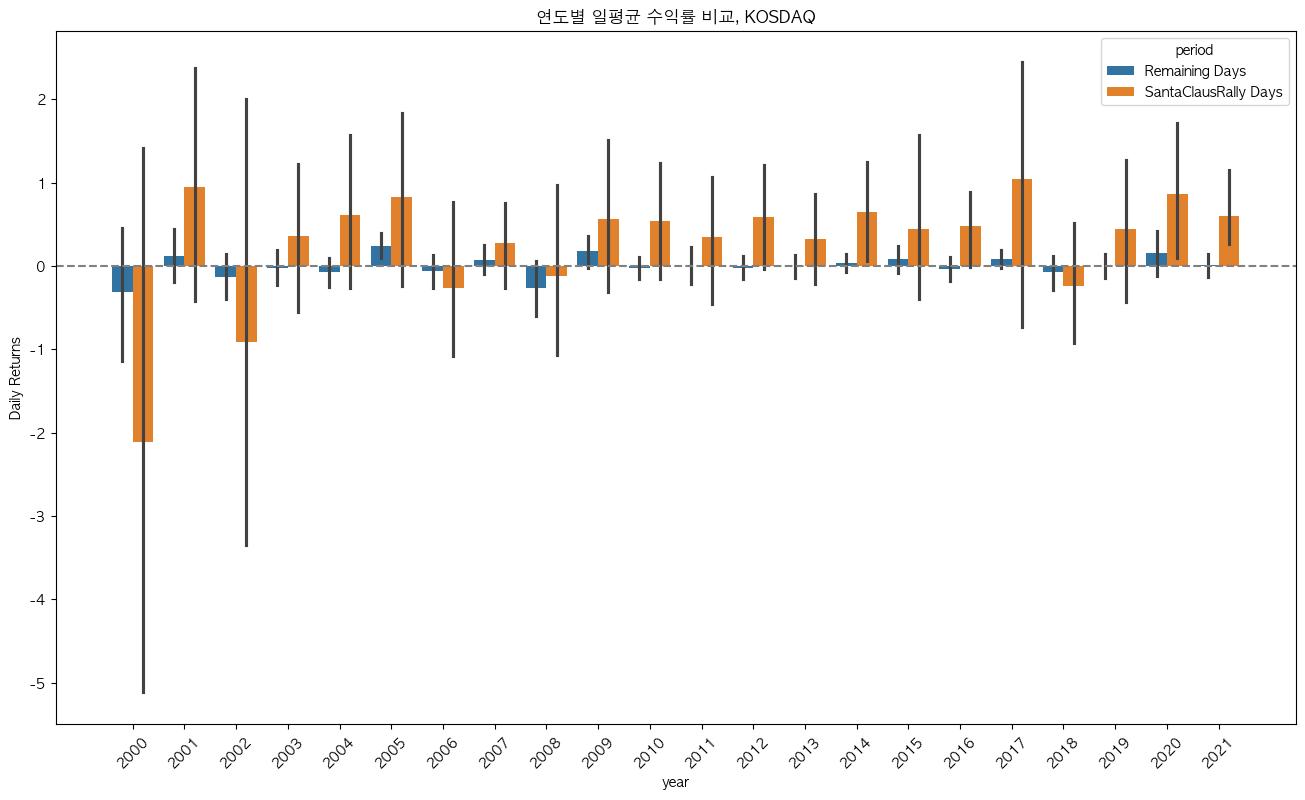

In [55]:
plt.figure(figsize=(16, 9))
sns.barplot(
    x=col_year, y=col_rtn, data=df.loc['2000-02':], hue=col_period, estimator=np.mean
)
plt.xticks(rotation=45)
plt.axhline(0, 0, 1, color='gray', linestyle='--')
plt.title(f'연도별 일평균 수익률 비교, {name}')
plt.plot()

### T-Test & Mann-Whitney U Test

In [36]:
res_test = pd.DataFrame(
    columns = ['T-Test', 'mann-Whitney U Test'],
    index = ['Statistic', 'p-value', 'df']
)

In [37]:
res_ttest = ttest_ind(
    rtns_santa, rtns_remaining, 
    equal_var=True, alternative='greater'
)
t_statistic = res_ttest.statistic
t_pvalue = res_ttest.pvalue
t_df = int(res_ttest.df)

res_test['T-Test'] = [t_statistic, t_pvalue, t_df]

In [38]:
res_utest = mannwhitneyu(
    rtns_santa, rtns_remaining,
    alternative='greater'
)
u_statistic = res_utest.statistic
u_pvalue = res_utest.pvalue

res_test['mann-Whitney U Test'] = [u_statistic, u_pvalue, '']

In [39]:
res_test

,T-Test,mann-Whitney U Test
Statistic,0.787487,416199.0
p-value,0.215515,0.463647
df,5534.000000,


### OLS Regression

In [40]:
res_ols = pd.DataFrame(
    index = [
        name, 'T-statistics', 'p-values'
    ],
    columns = [
        'Constant', 'Santa Rally Days', 'F-Value', 'Significance'
    ]
).fillna('')

In [41]:
y = df[col_rtn]
x = np.where(df[col_period]==val_period[1], 1, 0)
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

res_ols.loc[name] = results.params.values.tolist() + [results.fvalue, results.f_pvalue]
res_ols.loc['T-statistics'].iloc[:2] = results.tvalues.values.tolist()
res_ols.loc['p-values'].iloc[:2] = results.pvalues.values.tolist()

In [42]:
res_ols

,Constant,Santa Rally Days,F-Value,Significance
S&P500,0.026709,0.079608,0.620136,0.431031
T-statistics,1.584084,0.787487,,
p-values,0.113232,0.431031,,
